In [1]:
import pandas

'''
Imports
'''
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import pycountry_convert as pc
import time

from pprint import pprint
from typing import Tuple

from tqdm import tqdm
tqdm.pandas()

from matplotlib import pyplot as plt

from json import loads

ModuleNotFoundError: No module named 'pycountry_convert'

In [12]:
'''
Calculate continent for probes by their given longitude and latitude. Reads csv file, calculates continent and
outputs new csv file with a new column for the continent.
    Continent calculation code from:
    https://medium.com/bitgrit-data-science-publication/get-continent-names-from-coordinates-using-python-8560cdcfdfbb
'''
def get_continent_name(continent_code: str) -> str:
    continent_dict = {
        "NA": "North America",
        "SA": "South America",
        "AS": "Asia",
        "AF": "Africa",
        "OC": "Oceania",
        "EU": "Europe",
        "AQ" : "Antarctica"
    }
    return continent_dict[continent_code]

def get_continent(lat: float, lon: float) -> str:
    geolocator = Nominatim(user_agent="<username>@gmail.com", timeout=10)
    geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)
    location = geocode(f"{lat}, {lon}", language="en")

    # for cases where the location is not found, coordinates are antarctica
    if location is None:
        return "Antarctica", "Antarctica"

    # extract country code
    address = location.raw["address"]
    country_code = address["country_code"].upper()

    # get continent code from country code
    continent_code = pc.country_alpha2_to_continent_code(country_code)
    continent_name = get_continent_name(continent_code)
    return continent_name

# Load CSV containing coordinates
df = pd.read_csv('data/output.csv')

# Add continent column to the dataframe
df["continent"] = df.apply(lambda row: get_continent(row["latitude"], row["longitude"]), axis=1)

# Write the dataframe to updated csv
df.to_csv("data/coordinates_continents_selected_probes.csv", sep=',')

In [56]:
'''
Open csv file of selected probes and output statistics.
'''

# Load CSV containing coordinates
df_selected_probes = pd.read_csv('data/coordinates_continents_selected_probes.csv')
                      
df_continent_percentage_selected = df_selected_probes.groupby(by=["continent"]).count()['type']/len(df_selected_probes["type"])

In [57]:
'''
Open csv file of all RIPE Atlas probes and output statistics.
'''

# Load CSV containing coordinates
df_all_probes = pd.read_csv('data/coordinates_continents_all_probes.csv')
                      
df_continent_percentage_all = df_all_probes.groupby(by=["continent"]).count()['type']/len(df_all_probes["type"])

In [77]:
'''
Open csv file of global internet connectivity and output statistics.
'''

# Load CSV containing coordinates
df_global_internet_user_share = pd.read_csv('data/global_internet_users_share.csv')

print(df_global_internet_user_share)

         continent  share
0             Asia  0.578
1    South America  0.068
2    North America  0.073
3           Europe  0.130
4           Africa  0.074
5  Central America  0.026
6          Oceania  0.070


In [99]:
'''
Create dataframe showing probe selection by continent.
Requires all three previous blocks to have run in order to read files.
'''

# Create combined dataframe for all three sources
total_shares = df_continent_percentage_selected.to_frame().merge(df_continent_percentage_all.to_frame(), on="continent").merge(df_global_internet_user_share, on="continent", how="outer").rename(columns={"type_x":"Share selected probes", "type_y":"Share all probes", "share":"Global Share"})

# Replace NaN with 0
total_shares.fillna(0, inplace=True)

print(total_shares)

         continent  Share selected probes  Share all probes  Global Share
0           Africa                  0.016             0.016         0.074
1             Asia                  0.108             0.108         0.578
2           Europe                  0.628             0.628         0.130
3    North America                  0.188             0.188         0.073
4          Oceania                  0.036             0.036         0.070
5    South America                  0.024             0.024         0.068
6  Central America                  0.000             0.000         0.026


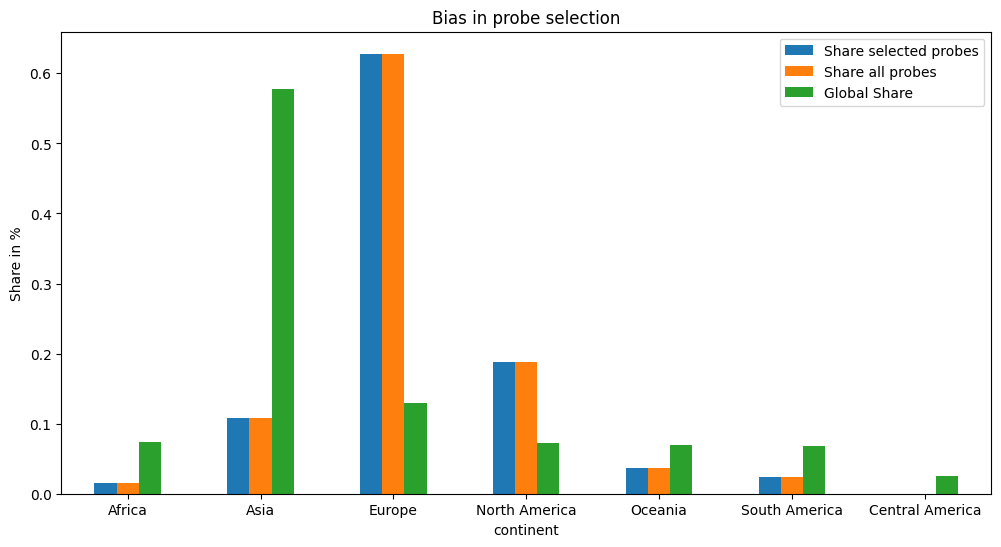

In [101]:
'''
Create plot for data.
'''
total_shares.plot(x='continent', y=['Share selected probes', 'Share all probes', 'Global Share'], kind='bar', title="Bias in probe selection", figsize=(12,6), ylabel='Share in %', rot=0);